## Serial LETK Filtering


In [1]:
import Simulator
import Observation
import Statistics

import KalmanFilter
import ETKalmanFilter
import SLETKalmanFilter
import IEWParticleFilter

import Comparer

## Loading simulator 

For Kalman filtering we have to be able to propagate a Gaussian distribution in time and to have access to the linear operators

In [2]:
timestamp = "2021_08_26-12_22_18"

grid, simulator = Simulator.from_file(timestamp)

## Loading observations 

Observation positions which are fixed for a setup and values from the truth

In [3]:
obs_timestamp = "2021_08_26-12_22_28"
observation = Observation.from_file(grid, timestamp, obs_timestamp)

Remember to set observation positions and to set/observe values!


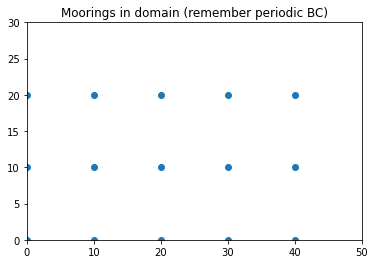

In [4]:
observation.plot_positions()

In [5]:
stop_simulation_early = True

if stop_simulation_early:
    observation.N_obs = 5


## Definition of initial distribution 

The inital state is equipped with a Gaussian distribution specified by its mean and covariance. 

In [6]:
prior_args = Statistics.prior_args_from_file(timestamp)

## New truth if changes intended

In [7]:
new_truth = False

In [8]:
if new_truth:
    observation.clear_observations()
    observation.set_regular_positions(10)
    observation.plot_positions()

    statistics_truth = Statistics.Statistics(simulator, 1)
    statistics_truth.set_prior(prior_args)

    for t in range(10):
        statistics_truth.propagate(25)
        statistics_truth.plot()
        observation.observe(statistics_truth.mean)

## Kalman filtering

Updating/conditioning the distributions at every observation time

Please remember to set priors!


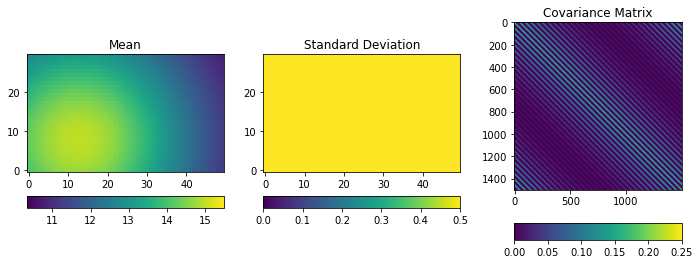

In [9]:
statistics_kf = Statistics.Statistics(simulator, safe_history=True)
statistics_kf.set_prior(prior_args)

statistics_kf.plot()

0


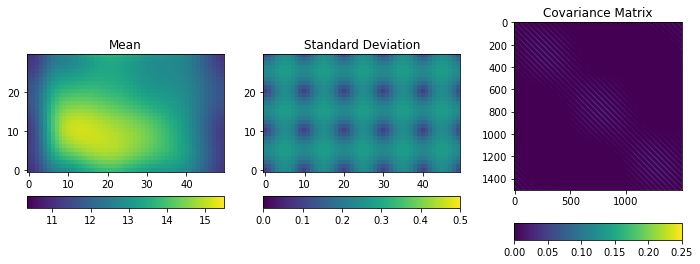

1


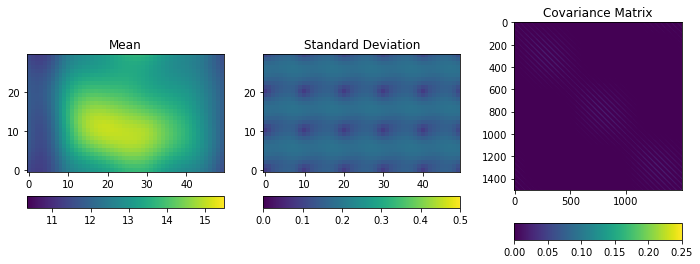

2


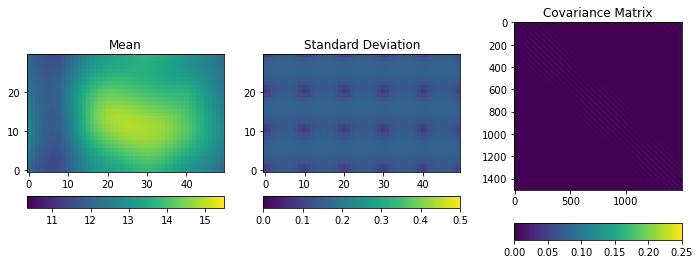

3


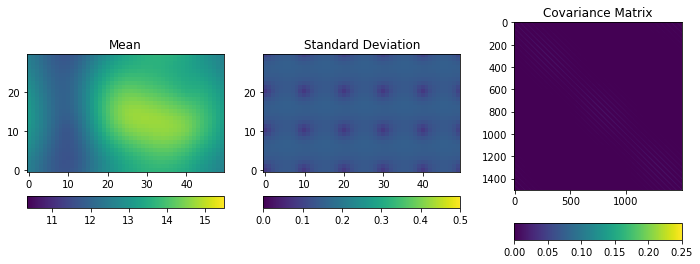

4


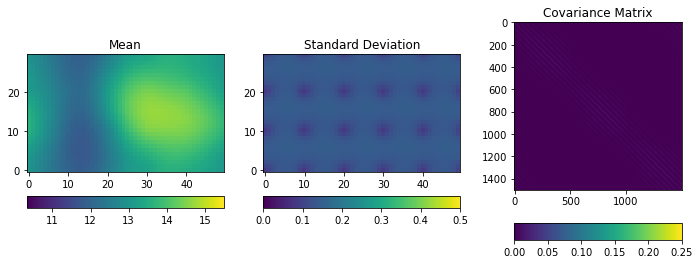

In [10]:
kalmanFilter = KalmanFilter.Kalman(statistics_kf, observation)

for t in range(observation.N_obs):
    print(t)
    statistics_kf.propagate(25)
    kalmanFilter.filter(statistics_kf.mean, statistics_kf.cov, observation.obses[t])
    statistics_kf.plot()

## ETKF filtering

Updating/conditioning the distributions at every observation time

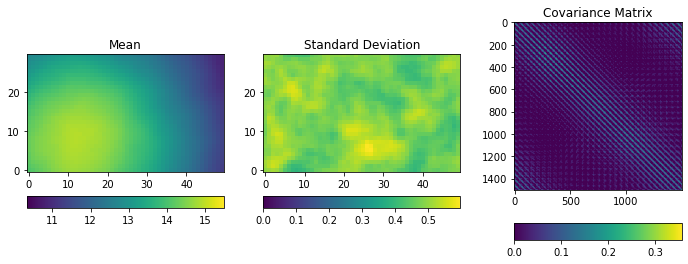

In [11]:
statistics_etkf = Statistics.Statistics(simulator, 100, safe_history=True)
statistics_etkf.set_prior(prior_args)

statistics_etkf.plot()

0


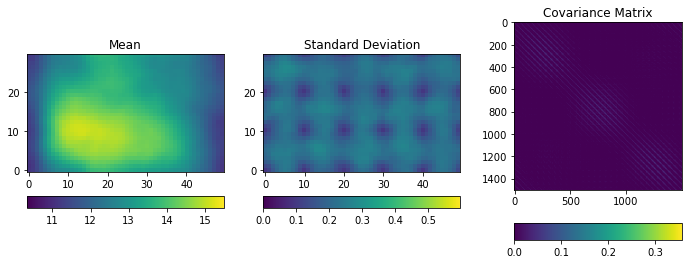

1


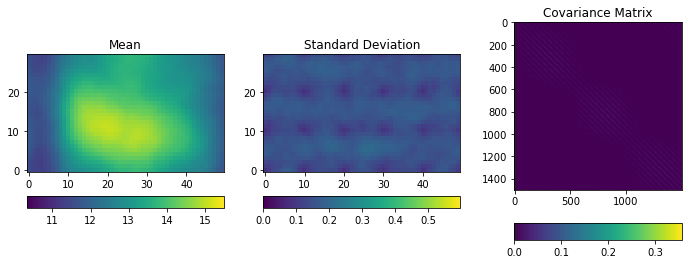

2


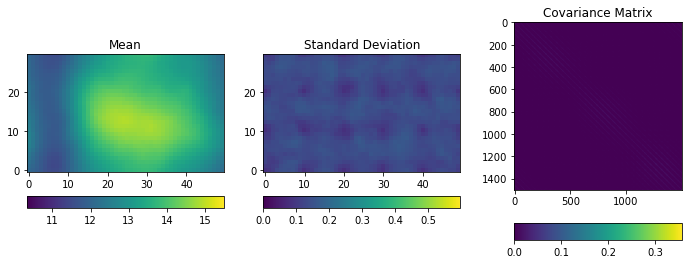

3


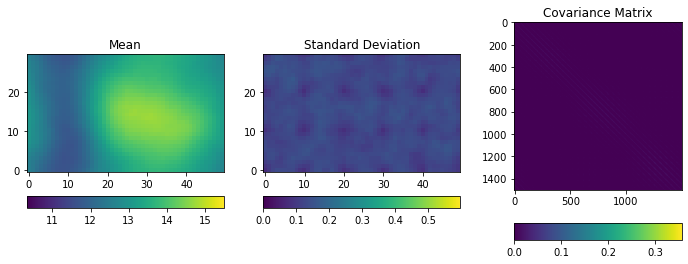

4


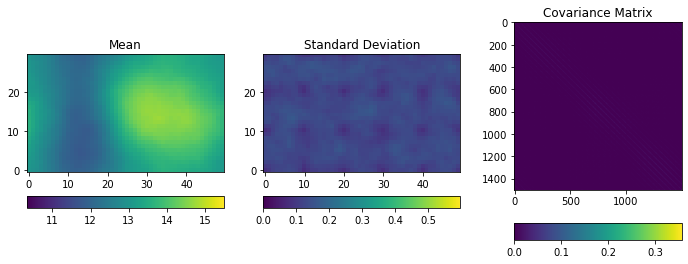

In [12]:
etkFilter = ETKalmanFilter.ETKalman(statistics_etkf, observation)

for t in range(observation.N_obs):
    print(t)
    statistics_etkf.propagate(25)
    etkFilter.filter(statistics_etkf.ensemble.ensemble, observation.obses[t])
    statistics_etkf.plot()

## LETKF filtering

Updating/conditioning the distributions at every observation time

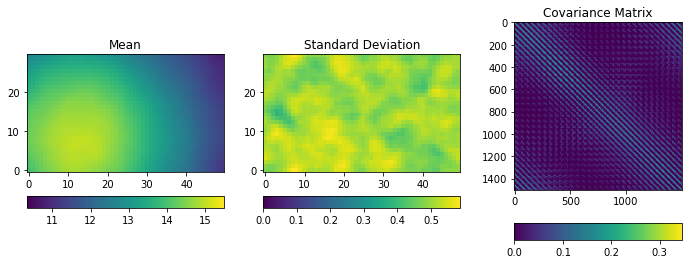

In [13]:
statistics_letkf = Statistics.Statistics(simulator, 100, safe_history=True)
statistics_letkf.set_prior(prior_args)

statistics_letkf.plot()

In [14]:
# We choose the scale_r as about 2/3 of the correlation length in grid cells 
scale_r = 8

In [15]:
sletkFilter = SLETKalmanFilter.SLETKalman(statistics_letkf, observation, scale_r)

In [16]:
sletkFilter.groups

[[0, 2, 6, 8, 14], [1, 4, 5, 7, 13], [11, 3, 9], [10, 12]]

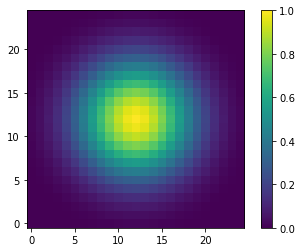

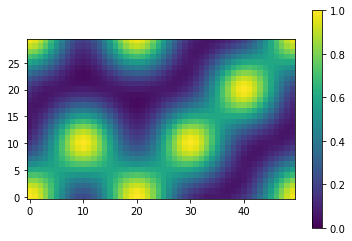

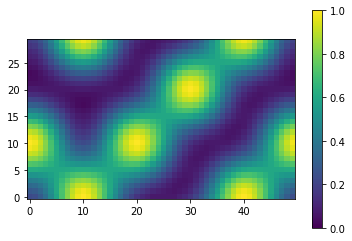

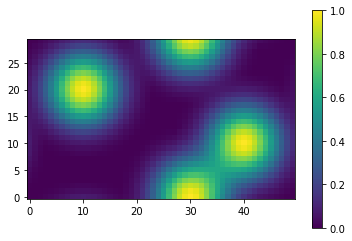

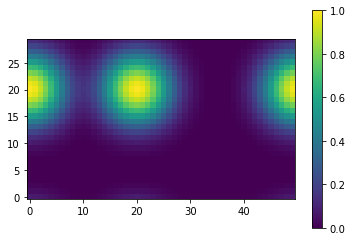

In [17]:
from matplotlib import pyplot as plt
plt.imshow(sletkFilter.W_loc, origin="lower", vmin=0.0, vmax=1.0)
plt.colorbar()
plt.show()
for g in range(len(sletkFilter.groups)):
    plt.imshow(sletkFilter.W_analyses[g], origin="lower", vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.show()

0


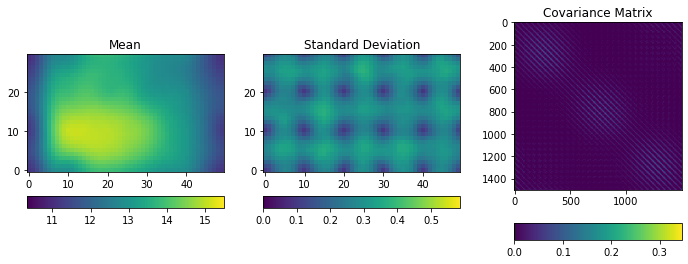

1


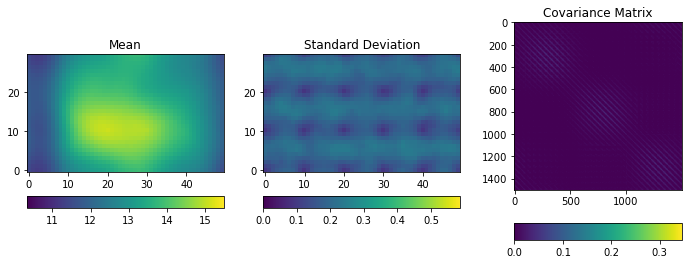

2


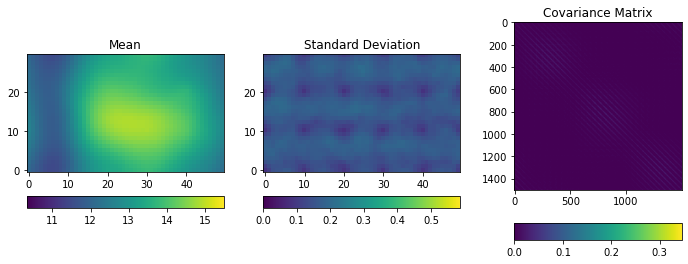

3


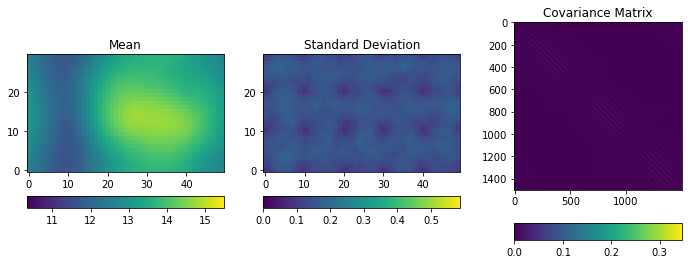

4


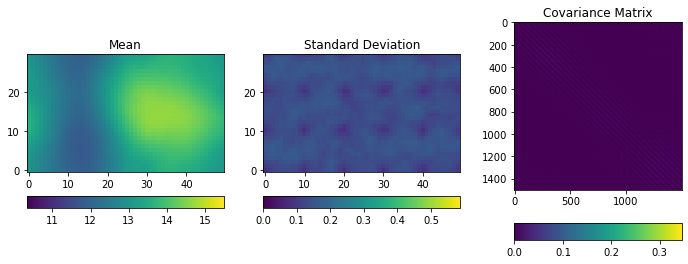

In [18]:
for t in range(observation.N_obs):
    print(t)
    statistics_letkf.propagate(25)
    sletkFilter.filter(statistics_letkf.ensemble.ensemble, observation.obses[t])
    statistics_letkf.plot()

## IEWPF filtering

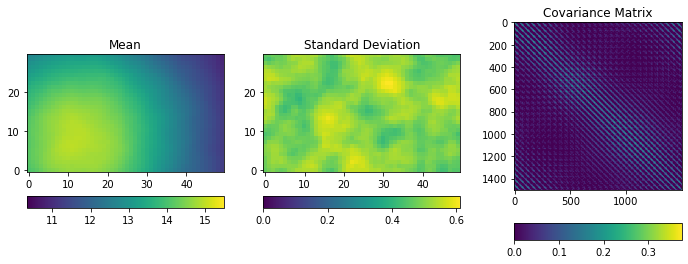

In [19]:
statistics_iewpf = Statistics.Statistics(simulator, 100, safe_history=True)
statistics_iewpf.set_prior(prior_args)

statistics_iewpf.plot()

In [20]:
from importlib import reload
reload(IEWParticleFilter)

<module 'IEWParticleFilter' from '/home/florianb/advectionDiffusion/IEWParticleFilter.py'>

0


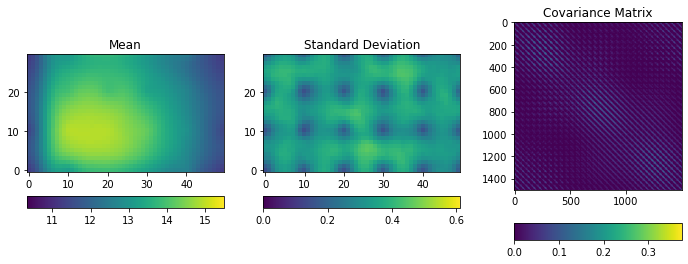

1


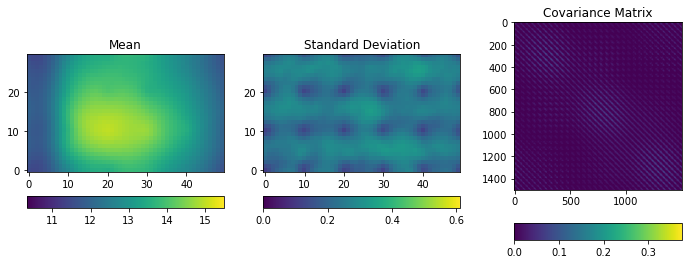

2


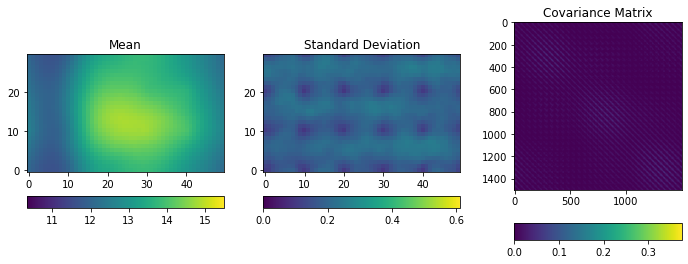

3


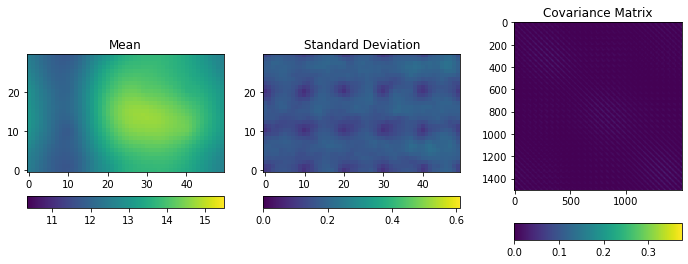

4


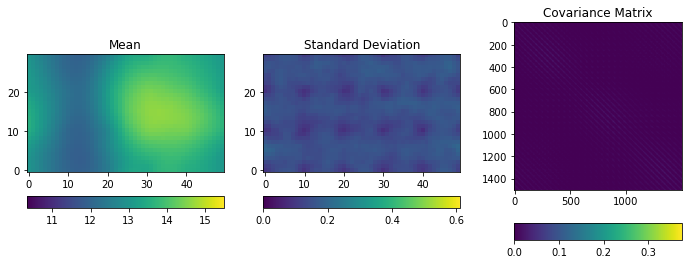

In [21]:
iewpFilter = IEWParticleFilter.IEWParticle(statistics_iewpf, observation, 0.5)

for t in range(observation.N_obs):
    print(t)
    statistics_iewpf.propagate(25, model_error=False)
    iewpFilter.filter(statistics_iewpf.ensemble.ensemble, observation.obses[t])
    statistics_iewpf.plot()

## Comparison

In [22]:
from importlib import reload  
reload(Comparer)

<module 'Comparer' from '/home/florianb/advectionDiffusion/Comparer.py'>

In [23]:
comparer = Comparer.Comparer(statistics_kf, statistics_etkf, statistics_letkf, statistics_iewpf)

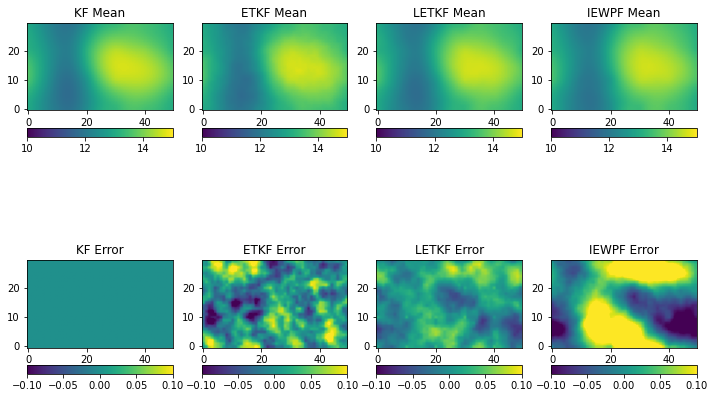

In [24]:
comparer.mean_plots()

In [25]:
mean_rmse_kf, mean_rmse_etkf, mean_rmse_letkf, mean_rmse_iewpf = comparer.mean_rmse()

print("RMSE of KF = ", mean_rmse_kf)
print("RMSE of ETKF = ", mean_rmse_etkf)
print("RMSE of LETKF = ", mean_rmse_letkf)
print("RMSE of IEWPF = ", mean_rmse_iewpf)

RMSE of KF =  0.0
RMSE of ETKF =  1.7345155692740155
RMSE of LETKF =  1.2338607765544305
RMSE of IEWPF =  3.6172872282227195


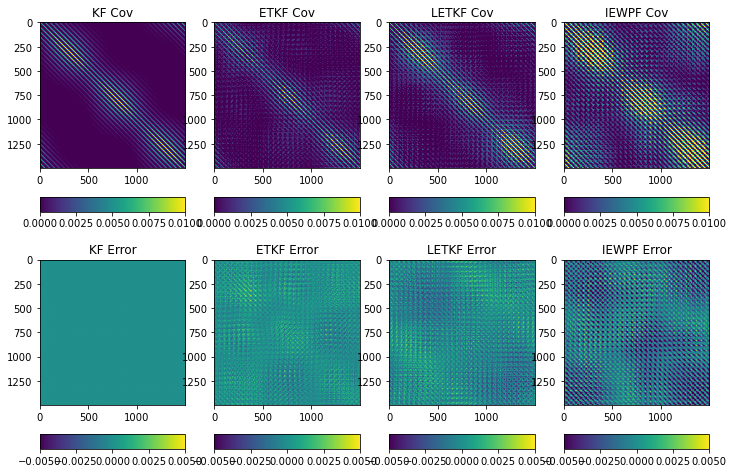

In [26]:
comparer.cov_plots()

In [27]:
cov_frob_kf, cov_frob_etkf, cov_frob_letkf, cov_frob_iewpf = comparer.cov_frobenius_dist()

print("Frobenius error in Cov matrix (KF) = ", cov_frob_kf)
print("Frobenius error in Cov matrix (ETKF) = ", cov_frob_etkf)
print("Frobenius error in Cov matrix (LETKF) = ", cov_frob_letkf)
print("Frobenius error in Cov matrix (IEWPF) = ", cov_frob_iewpf)

Frobenius error in Cov matrix (KF) =  0.0
Frobenius error in Cov matrix (ETKF) =  2.44779293966234
Frobenius error in Cov matrix (LETKF) =  3.0420817602519
Frobenius error in Cov matrix (IEWPF) =  4.810322814152974


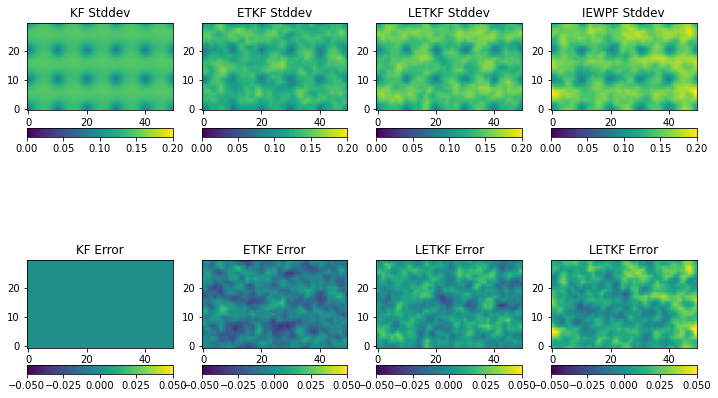

In [28]:
comparer.stddev_plots()

In [29]:
stddev_rmse_kf, stddev_rmse_etkf, stddev_rmse_letkf, stddev_rmse_iewpf = comparer.stddev_rmse()

print("RMSE of KF = ", stddev_rmse_kf)
print("RMSE of ETKF = ", stddev_rmse_etkf)
print("RMSE of LETKF = ", stddev_rmse_letkf)
print("RMSE of IEWPF = ", stddev_rmse_iewpf)

RMSE of KF =  0.0
RMSE of ETKF =  0.4576920329138819
RMSE of LETKF =  0.38169674773787304
RMSE of IEWPF =  0.5971998188453899


In [30]:
reload(Comparer)
comparer = Comparer.Comparer(statistics_kf, statistics_etkf, statistics_letkf, statistics_iewpf)

In [31]:
comparer.set_poi([0,0])
comparer.set_poi([25,15])
comparer.set_poi([1,0])

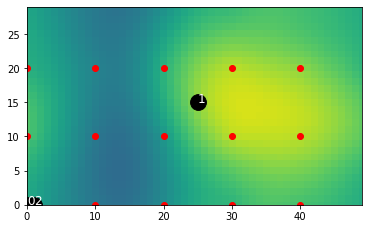

In [32]:
comparer.poi_plot(observation)

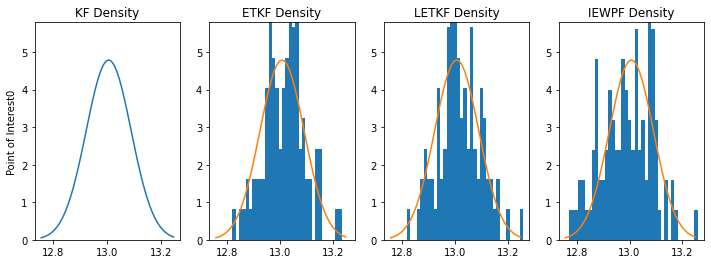

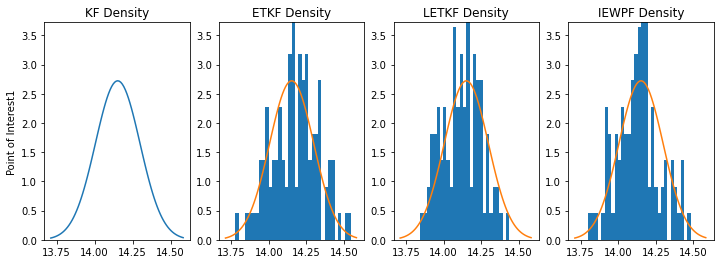

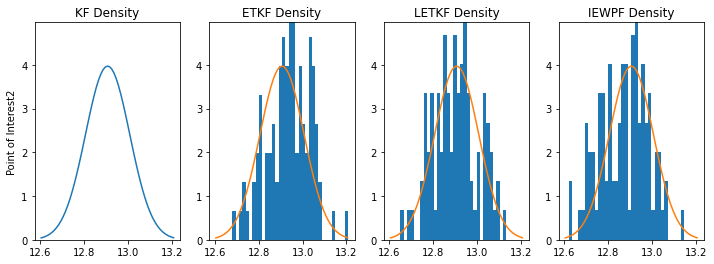

In [33]:
comparer.poi_hist(0)
comparer.poi_hist(1)
comparer.poi_hist(2)

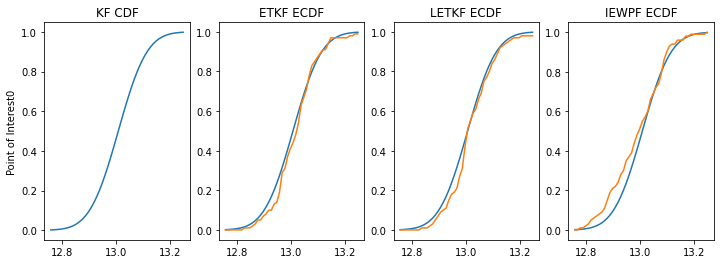

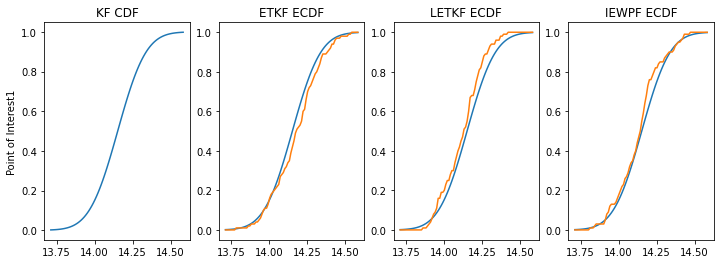

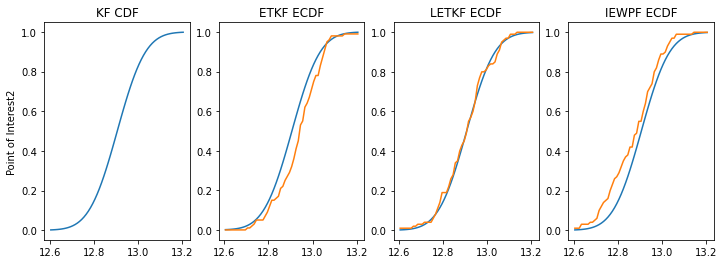

In [34]:
comparer.poi_ecdf_plots(0)
comparer.poi_ecdf_plots(1)
comparer.poi_ecdf_plots(2)

In [35]:
ecdf_err_etkf, ecdf_err_letkf, ecdf_err_iewpf = comparer.poi_ecdf_err(0)

print("Difference at pos0 (ETKF) = ", ecdf_err_etkf)
print("Difference at pos0 (LETKF) = ",ecdf_err_letkf)
print("Difference at pos0 (IEWPF) = ",ecdf_err_iewpf)

ecdf_err_etkf, ecdf_err_letkf, ecdf_err_iewpf = comparer.poi_ecdf_err(1)

print("Difference at pos1 (ETKF) = ", ecdf_err_etkf)
print("Difference at pos1 (LETKF) = ",ecdf_err_letkf)
print("Difference at pos1 (IEWPF) = ",ecdf_err_iewpf)

ecdf_err_etkf, ecdf_err_letkf, ecdf_err_iewpf = comparer.poi_ecdf_err(2)

print("Difference at pos2 (ETKF) = ", ecdf_err_etkf)
print("Difference at pos2 (LETKF) = ",ecdf_err_letkf)
print("Difference at pos2 (IEWPF) = ",ecdf_err_iewpf)

/home/florianb/advectionDiffusion/Comparer.py:353: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  ecdf_err_etkf = scipy.integrate.quad(diff_etkf, xmin, xmax, limit=100)[0]
/home/florianb/advectionDiffusion/Comparer.py:354: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and call

Difference at pos0 (ETKF) =  0.011847989759430267
Difference at pos0 (LETKF) =  0.01267147319730484
Difference at pos0 (IEWPF) =  0.01963752140276205
Difference at pos1 (ETKF) =  0.025615161014769194
Difference at pos1 (LETKF) =  0.03386572355334647
Difference at pos1 (IEWPF) =  0.020973911865461985
Difference at pos2 (ETKF) =  0.031376600826201334
Difference at pos2 (LETKF) =  0.009204872741739138
Difference at pos2 (IEWPF) =  0.03493525579643658


## Correlation Study

Analytic correlation of two points $s_0$ at time $t_0$ and $s_1$ at time $t_1 = t_0 + \Delta t$ where sites are chosen in advection direction

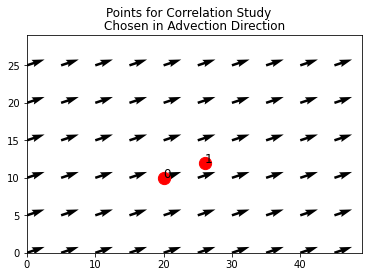

In [36]:
points = [[20,10],[26,12]]

simulator.plot_correlation_points(points)


Analytical calculations as suggested by Jo

In [37]:
statistics_kf.evaluate_correlation(points)

0.2558367799662169

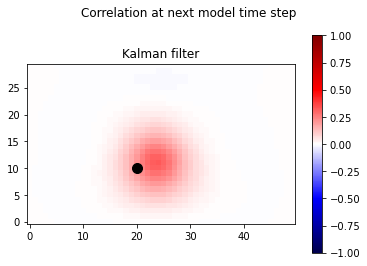

In [38]:
import numpy as np

corr_grid_kf = np.zeros((grid.nx, grid.ny))
for x in range(grid.nx):
    for y in range(grid.ny):
        corr_grid_kf[x,y] = statistics_kf.evaluate_correlation([[20,10],[x,y]])
        
plt.suptitle("Correlation at next model time step")
plt.title("Kalman filter")
plt.imshow(corr_grid_kf.T, vmin=-1, vmax=1, cmap="seismic", origin="lower")
plt.colorbar()
plt.scatter(20, 10, s=100, c="black")
plt.show()

Empirical estimations

$Corr = \frac{1}{N_e-1} \frac{1}{\sigma_{t=9}(x_0)\sigma_{t=10}(x_2)} \sum (c^e_{t=9}(x_0) - \overline{c_{t=9}(x_0)})(c^e_{t=10}(x_1) - \overline{c_{t=10}(x_1)}) $

In [39]:
statistics_etkf.evaluate_correlation(points)

0.16849218930226537

In [40]:
statistics_letkf.evaluate_correlation(points)

0.31238584192304775

In [41]:
statistics_iewpf.evaluate_correlation(points)

0.703377975559111

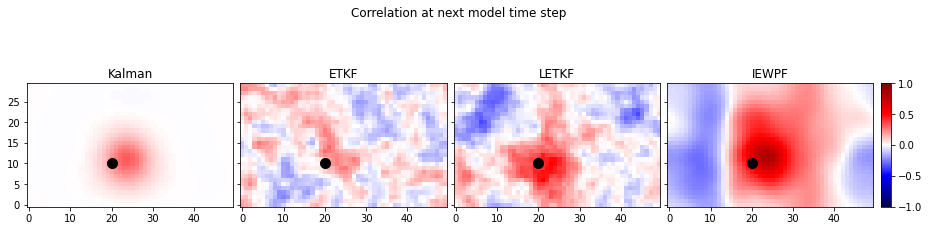

In [42]:
corr_grid_etkf = np.zeros((grid.nx, grid.ny))
corr_grid_letkf = np.zeros((grid.nx, grid.ny))
corr_grid_iewpf = np.zeros((grid.nx, grid.ny)) 
for x in range(grid.nx):
    for y in range(grid.ny):
        corr_grid_etkf[x,y] = statistics_etkf.evaluate_correlation([[20,10],[x,y]])
        corr_grid_letkf[x,y] = statistics_letkf.evaluate_correlation([[20,10],[x,y]])
        corr_grid_iewpf[x,y] = statistics_iewpf.evaluate_correlation([[20,10],[x,y]])

from mpl_toolkits.axes_grid1 import AxesGrid

fig = plt.figure(figsize=(12,4))
fig.suptitle("Correlation at next model time step")

axs = AxesGrid(fig, (0.0,0.0,1.0,1.0), nrows_ncols=(1,4), axes_pad=0.1,
    cbar_mode="single", cbar_location="right", cbar_pad=0.1)

fig0 = axs[0].imshow(corr_grid_kf.T, vmin=-1, vmax=1, cmap="seismic", origin="lower")
axs[0].set_title("Kalman")
axs[0].scatter(20, 10, s=100, c="black")

fig1 = axs[1].imshow(corr_grid_etkf.T, vmin=-1, vmax=1, cmap="seismic", origin="lower")
axs[1].set_title("ETKF")
axs[1].scatter(20, 10, s=100, c="black")

fig2 = axs[2].imshow(corr_grid_letkf.T, vmin=-1, vmax=1, cmap="seismic", origin="lower")
axs[2].set_title("LETKF")
axs[2].scatter(20, 10, s=100, c="black")

fig3 = axs[3].imshow(corr_grid_iewpf.T, vmin=-1, vmax=1, cmap="seismic", origin="lower")
axs[3].set_title("IEWPF")
axs[3].scatter(20, 10, s=100, c="black")

cbar = axs[0].cax.colorbar(fig3)

plt.show()

In [43]:
print("Maximal correlation KF", np.max(corr_grid_kf))
print("Maximal correlation ETKF", np.max(corr_grid_etkf))
print("Maximal correlation LETKF", np.max(corr_grid_letkf))
print("Maximal correlation IEWPF", np.max(corr_grid_iewpf))

Maximal correlation KF 0.3226473045715745
Maximal correlation ETKF 0.28928101712656834
Maximal correlation LETKF 0.49848681555553503
Maximal correlation IEWPF 0.8183221297530824


In [44]:
import numpy as np
print("ETKF difference ",  np.linalg.norm(corr_grid_kf - corr_grid_etkf))
print("LETKF difference ", np.linalg.norm(corr_grid_kf - corr_grid_letkf))
print("IEWPF difference ", np.linalg.norm(corr_grid_kf - corr_grid_iewpf))

ETKF difference  3.6428843318529927
LETKF difference  4.764545354037784
IEWPF difference  7.831116008017503


In [45]:
print("ETKF difference close to max ",  np.linalg.norm((corr_grid_kf - corr_grid_etkf)*(corr_grid_kf>0.1)))
print("LETKF difference close to max ", np.linalg.norm((corr_grid_kf - corr_grid_letkf)*(corr_grid_kf>0.1)))
print("IEWPF difference close to max ", np.linalg.norm((corr_grid_kf - corr_grid_iewpf)*(corr_grid_kf>0.1)))

ETKF difference close to max  1.1394323413708112
LETKF difference close to max  1.7430770942023759
IEWPF difference close to max  4.174594407618639


In [46]:
print("ETKF difference far away max ",  np.linalg.norm((corr_grid_kf - corr_grid_etkf)*(corr_grid_kf<0.1)))
print("LETKF difference far away max ", np.linalg.norm((corr_grid_kf - corr_grid_letkf)*(corr_grid_kf<0.1)))
print("IEWPF difference far away max ", np.linalg.norm((corr_grid_kf - corr_grid_iewpf)*(corr_grid_kf<0.1)))

ETKF difference far away max  3.4601011827254786
LETKF difference far away max  4.434250181750014
IEWPF difference far away max  6.625642569812166


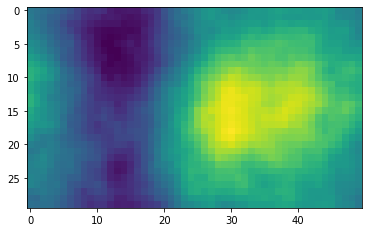

In [47]:
from matplotlib import pyplot as plt
plt.imshow(np.reshape(statistics_letkf.ensemble.ensemble[:,0], (grid.ny,grid.nx)))

# Plots for paper 

In [48]:
import numpy as np
np.arange(0,1,1/50)+1/50

array([0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 , 0.22,
       0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42, 0.44,
       0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64, 0.66,
       0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86, 0.88,
       0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ])